In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *
from data_retrieve import *
from gbm import *

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
last_id = 287
backtest_start = 187
backtest_end = 192
h = 0.01

In [17]:
combined_df.iloc[backtest_start], combined_df.iloc[backtest_end]

(Date               2024-07-25 00:00:00
 ROG_Last_Price                   277.5
 ROG_IVOL                       18.2666
 CFR_Last_Price                   131.2
 CFR_IVOL                        23.415
 ZURN_Last_Price                  474.6
 ZURN_IVOL                      14.5858
 Risk_Free_Rate                  0.8649
 Name: 187, dtype: object,
 Date               2024-08-02 00:00:00
 ROG_Last_Price                   281.1
 ROG_IVOL                        19.105
 CFR_Last_Price                  127.55
 CFR_IVOL                       25.4086
 ZURN_Last_Price                  466.3
 ZURN_IVOL                      17.6032
 Risk_Free_Rate                  0.8528
 Name: 192, dtype: object)

In [18]:
tickers = ['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']

# Getting Delta and gammas

1m43s: original

## TS GREEKS CELL

In [19]:


prices = []
prices_up = {}
prices_down = {}
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    prices_up[t] = []
    prices_down[t] = []
    

h = 0.01
n_paths = 100
drift = 0.01107# overwrriten by GBMTS
risk_neutral = False
implied_volatility = True
drifts = []
for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers, drift = MultivariateGBMSimulationTS(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, window_size=30, implied_volatility=implied_volatility, h=h)
    drift = np.array(drift)
    drifts.append(drift[0] / 100)
    # result, tickers = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, drift=drift, window_size=30, implied_volatility=implied_volatility, h=h)


    old_path = {}
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        old_path[t] = combined_df[t].iloc[:current_id]
        payoff_up[t] = []
        payoff_down[t] = []        
    path_rog = [[], [], []]
    path_cfr = [[], [], []]
    path_zurn = [[], [], []]
    for i in range(result.shape[-2]):
        path_rog[0].append(np.append(old_path[tickers[0]], result[0][0][i].flatten()))
        path_cfr[0].append(np.append(old_path[tickers[1]], result[0][1][i].flatten()))
        path_zurn[0].append(np.append(old_path[tickers[2]], result[0][2][i].flatten()))

        path_rog[1].append(np.append(old_path[tickers[0]], result[1][0][i].flatten()))
        path_cfr[1].append(np.append(old_path[tickers[1]], result[1][1][i].flatten()))
        path_zurn[1].append(np.append(old_path[tickers[2]], result[1][2][i].flatten()))

        path_rog[2].append(np.append(old_path[tickers[0]], result[2][0][i].flatten()))
        path_cfr[2].append(np.append(old_path[tickers[1]], result[2][1][i].flatten()))
        path_zurn[2].append(np.append(old_path[tickers[2]], result[2][2][i].flatten()))
        
    payoff = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)



    up = payoff_func_parallel(path_rog[1], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[2], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['ROG_Last_Price'] = up
    payoff_down['ROG_Last_Price'] = down

    up = payoff_func_parallel(path_rog[0], path_cfr[1], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[0], path_cfr[2], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['CFR_Last_Price'] = up
    payoff_down['CFR_Last_Price'] = down
    up = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[1], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[2], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['ZURN_Last_Price'] = up
    payoff_down['ZURN_Last_Price'] = down
    
    for t in tickers:
        prices_up[t].append(np.mean(payoff_up[t]))
        prices_down[t].append(np.mean(payoff_down[t]))
    prices.append(np.mean(payoff))

prices = np.array(prices)

for t in tickers:
    prices_up[t] = np.array(prices_up[t])
    prices_down[t] = np.array(prices_down[t])

for t in tickers:
   deltas[t].append(np.exp(-np.mean(drifts) * (last_id - current_id)) * (prices_up[t] - prices_down[t]) / (2 * h))
   gammas[t].append(np.exp(-np.mean(drifts) * (last_id - current_id)) * (prices_up[t] - prices * 2 + prices_down[t]) / (h * h))

100%|██████████| 5/5 [00:00<00:00, 18.36it/s]


## AV GREEKS CELL

In [25]:
prices = []
prices_up = {}
prices_down = {}
deltas = {}
gammas = {}

for t in tickers:
    gammas[t] = []
    deltas[t] = []
    prices_up[t] = []
    prices_down[t] = []
    

h = 0.01
n_paths = 10000
drift = 0.01107# overwrriten by GBMTS
risk_neutral = True
implied_volatility = True

# drifts = []
for current_id in tqdm(range(backtest_start, backtest_end)):
    payoff = []
    result, tickers = MultivariateGBMSimulationAV(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, window_size=30, implied_volatility=implied_volatility, h=h)
    drift = np.array([drift])
    # drifts.append(drift[0] / 100)
    # result, tickers = MultivariateGBMSimulation(s0=close.iloc[current_id], n_paths=n_paths, current_id=current_id, drift=drift, window_size=30, implied_volatility=implied_volatility, h=h)


    old_path = {}
    payoff_up = {}
    payoff_down = {}
    for t in tickers:
        old_path[t] = combined_df[t].iloc[:current_id]
        payoff_up[t] = []
        payoff_down[t] = []        
    path_rog = [[], [], []]
    path_cfr = [[], [], []]
    path_zurn = [[], [], []]
    for i in range(result.shape[-2]):
        path_rog[0].append(np.append(old_path[tickers[0]], result[0][0][i].flatten()))
        path_cfr[0].append(np.append(old_path[tickers[1]], result[0][1][i].flatten()))
        path_zurn[0].append(np.append(old_path[tickers[2]], result[0][2][i].flatten()))

        path_rog[1].append(np.append(old_path[tickers[0]], result[1][0][i].flatten()))
        path_cfr[1].append(np.append(old_path[tickers[1]], result[1][1][i].flatten()))
        path_zurn[1].append(np.append(old_path[tickers[2]], result[1][2][i].flatten()))

        path_rog[2].append(np.append(old_path[tickers[0]], result[2][0][i].flatten()))
        path_cfr[2].append(np.append(old_path[tickers[1]], result[2][1][i].flatten()))
        path_zurn[2].append(np.append(old_path[tickers[2]], result[2][2][i].flatten()))
        
    payoff = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)



    up = payoff_func_parallel(path_rog[1], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[2], path_cfr[0], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['ROG_Last_Price'] = up
    payoff_down['ROG_Last_Price'] = down

    up = payoff_func_parallel(path_rog[0], path_cfr[1], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[0], path_cfr[2], path_zurn[0], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['CFR_Last_Price'] = up
    payoff_down['CFR_Last_Price'] = down
    up = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[1], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    down = payoff_func_parallel(path_rog[0], path_cfr[0], path_zurn[2], combined_df.iloc[current_id]['Date'], risk_free=drift, risk_neutral=risk_neutral, verbose=False)
    payoff_up['ZURN_Last_Price'] = up
    payoff_down['ZURN_Last_Price'] = down
    
    for t in tickers:
        prices_up[t].append(np.mean(payoff_up[t]))
        prices_down[t].append(np.mean(payoff_down[t]))
    prices.append(np.mean(payoff))

prices = np.array(prices)

for t in tickers:
    prices_up[t] = np.array(prices_up[t])
    prices_down[t] = np.array(prices_down[t])

for t in tickers:
   deltas[t].append(np.exp(-np.mean(drifts) * (last_id - current_id)) * (prices_up[t] - prices_down[t]) / (2 * h))
   gammas[t].append(np.exp(-np.mean(drifts) * (last_id - current_id)) * (prices_up[t] - prices * 2 + prices_down[t]) / (h * h))

deltas

100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


{'ROG_Last_Price': [array([0., 0., 0., 0., 0.])],
 'CFR_Last_Price': [array([0.77419371, 0.78768999, 0.65652693, 0.        , 0.        ])],
 'ZURN_Last_Price': [array([0., 0., 0., 0., 0.])]}

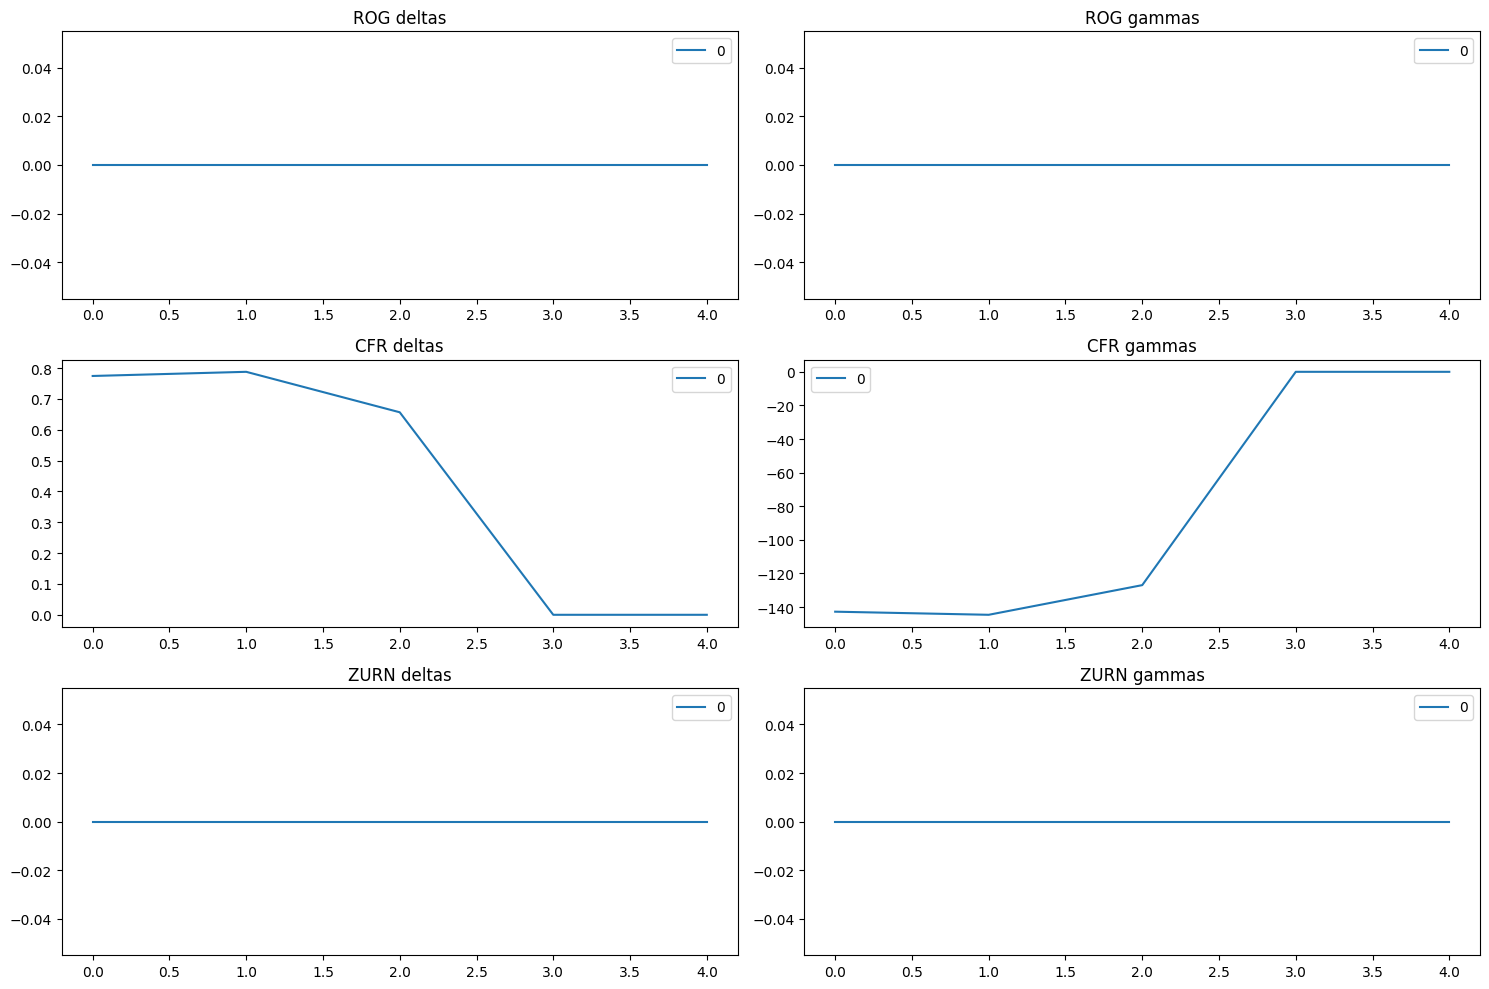

In [26]:
labels = ['ROG', 'CFR', 'ZURN']
f, axes = plt.subplots(3, 2, figsize=(15, 10))
for i, t in enumerate(tickers):
    sns.lineplot(deltas[t], ax=axes[i][0])
    axes[i][0].set_title(f'{labels[i]} deltas')
    sns.lineplot(gammas[t], ax=axes[i][1])
    axes[i][1].set_title(f'{labels[i]} gammas')

plt.tight_layout()

In [751]:
price_1 = [prices]

In [752]:
price_1

[array([ 970.31111698,  975.43681354, 1022.24419128, 1010.51846728,
        1014.48374001])]

2095.0976144263427


/home/bach/mh4518_simulation_in_fin/notebooks/../utils/utils.py:241: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


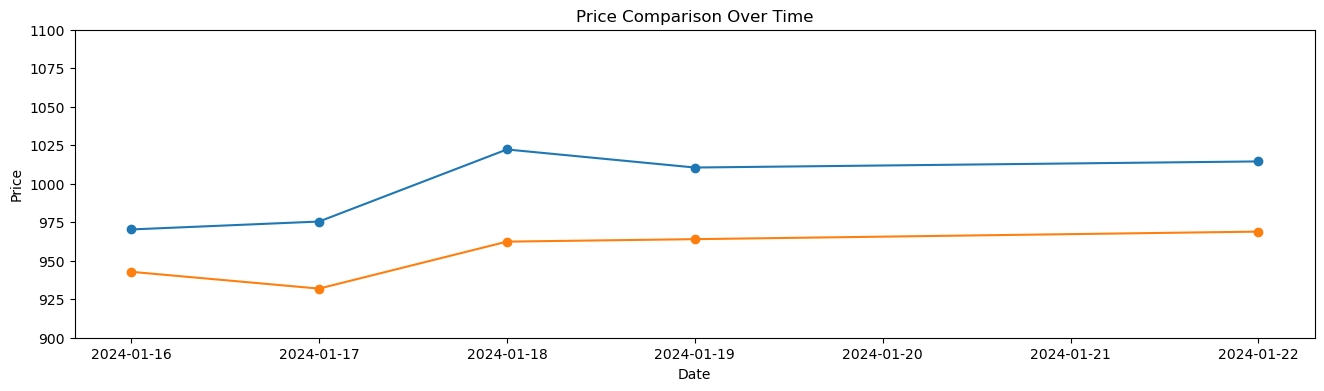

In [754]:
combined_df = retrieve_data()

evaluation_plot(
    backtest_start,
    backtest_end,
    combined_df,
    price_1,
    ylim=(900, 1100)
    )